![](https://lh3.googleusercontent.com/proxy/z9ilC4bvRfBqWs83SCvP_xo8V7eGgsilTqugH0axpWybkxLXuZk87CApVuuOrbbeXRa10Ungs5oHfhnNeda5uyMdSjrwcg8uSJXFW1kZvLJmXERERxuZIVovtwlYB_xhYhgkewkGqBH0V0POEio)

# Alocação Latente de Dirichlet (LDA)

*"No processamento de linguagem natural, a Alocação Latente de Dirichlet (LDA) é um <mark>modelo estatístico generativo que permite que conjuntos de observações sejam explicados por grupos não observados que explicam o porquê algumas partes dos dados são semelhantes</mark>. Por exemplo, se as observações são palavras coletadas em documentos, ele postula que cada documento é uma mistura de um pequeno número de tópicos e que a criação de cada palavra é atribuível a um dos tópicos do documento"*


# LDAvis

LDAvis são ferramentas para criar uma <mark>visualização interativa usando página web</mark>, de um modelo de tópico que foi ajustado a um corpus de dados de texto usando a **Alocação de Dirichlet Latente (LDA)**. Dado os parâmetros estimados do modelo de tópico, ele calcula várias estatísticas de resumo como entrada para uma visualização interativa criada com o D3.js que é acessada por meio de um navegador. <mark>O objetivo é ajudar os usuários a interpretar os tópicos em seu modelo de tópico LDA</mark>.

* [LDAvis Introduction](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf)

In [8]:
#pip install pyLDAvis

In [10]:
import numpy as np
import pandas as pd
import re, nltk, gensim
import requests
import json
#from sklearn.externals import joblib
import joblib

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Importando os Dados

In [11]:
filename = "samba_dataset.csv"
df = pd.read_csv(filename, sep="|")
df.head(3)

,musica,artista,compositor,letra
0,Eu Não Sou Manivela,Ary Barroso,Ary Barroso - 1953,Você não tem nem a metade Do valor que tinha ...
1,Mulata Beleza,Arlindo Cruz,Zé Roberto,Eu também fico o dia todo na janela Esperando...
2,Vai Pro Lado de Lá,Candeia,"Candeia, Euclenes",Vai pro lado de lá Vai pro lado de lá Vai pro...


# Tratando o texto

In [12]:
# cada letra de samba é um documento
data = [lyrics for lyrics in df.letra] 
print("Temos %d documentos." %len(data))

Temos 3118 documentos.


### Tokenização dos docs

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['voce', 'nao', 'tem', 'nem', 'metade', 'do', 'valor', 'que', 'tinha', 'outrora', 'mudou', 'mudou', 'mudou', 'so', 'chega', 'em', 'casa', 'pra', 'dormir', 'fora', 'de', 'hora', 'nao', 'suporto', 'mais', 'manivela', 'que', 'vai', 'pra', 'frente', 'pra', 'traz', 'hoje', 'vem', 'me', 'abraca', 'amanha', 'nem', 'me', 'conhece', 'quando', 'passa', 'nao', 'suporto', 'mais', 'manivela', 'que', 'vai', 'pra', 'frente', 'pra', 'traz', 'ficha', 'tecnica', 'da', 'faixa', 'conjunto', 'regional', 'voz', 'diamantina', 'gomes', 'samba', 'interprete', 'diamantina', 'gomes', 'com', 'regional', 'odeon']]


### Removendo Stopwords

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LeonardoLins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def removeStops(texts, stopwords):
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join([token for token in sent if token not in stopwords]))
    return texts_out


stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords += ["nao", "so", "pra", "pro", "pras", "pros"]
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_without_stops = removeStops(data_words, stopwords)

# sem stopwords
print(data_without_stops[:2])

['voce metade valor outrora mudou mudou mudou chega casa dormir hora suporto manivela vai frente traz hoje vem abraca amanha conhece passa suporto manivela vai frente traz ficha tecnica faixa conjunto regional voz diamantina gomes samba interprete diamantina gomes regional odeon', 'tambem fico dia todo janela esperando mulata bela bairro passar demais diferente nunca vi mulher tao atraente faz qualquer homem cuca virar femea rebolado sensacao cabelos sao longos corpo igual violao sigo passos sei faco cair bracos vou morrer paixao']


# Criando a matriz Documento-Palavra

O algoritmo de modelo de tópico LDA requer uma matriz de palavras do documento como entrada principal.

Você pode criar um usando o CountVectorizer. No código abaixo, eu configurei o CountVectorizer para considerar palavras que ocorreram pelo menos 10 vezes (min_df), remova palavras irrelevantes em inglês, converta todas as palavras em minúsculas e uma palavra pode conter números e alfabetos de pelo menos 3 para ser qualificado como uma palavra.

In [16]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             # stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

# data_vectorized = vectorizer.fit_transform(data_lemmatized)
data_vectorized = vectorizer.fit_transform(data_without_stops)

# Verificando quão Esparsa é a Matriz

Basta verificar a porcentagem de pontos diferentes de zero na matriz documento-palavra.

Como a maioria das células nessa matriz será zero, estou interessado em saber qual porcentagem de células contém valores diferentes de zero.

In [17]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", round(((data_dense > 0).sum()/data_dense.size)*100, 2), "%")

Sparsicity:  1.52 %


# Treinando o Modelo LDA com Sklearn

Tudo está pronto para criar um modelo de Alocação Dirichlet Latente (LDA). Vamos inicializar um e chamar fit_transform () para criar o modelo LDA.

Neste exemplo, eu defini os n_topics como 5. Mais tarde, encontraremos o número ideal usando grid search.

In [18]:
lda_model = LatentDirichletAllocation(n_components=4,              
                                      max_iter=10,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1             
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)

KeyboardInterrupt: 

# Avaliando a performance do modelo com a perplexidade e probabilidade logarítmica

Um modelo com maior probabilidade logarítmica e menor perplexidade (exp (-1. * Probabilidade logarítmica por palavra)) é considerado bom. Vamos verificar o nosso modelo.

In [10]:
# Probabilidade logaritmica: quanto maior melhor
print("probabilidade logaritmica: ", round(lda_model.score(data_vectorized), 2))

# Perplexidade: menor melhor.  exp(-1. * log-Probabilidade logaritmica por palavra)
print("Perplexidade: ", round(lda_model.perplexity(data_vectorized), 2))

print("Parâmetros:")
pprint(lda_model.get_params())

probabilidade logaritmica:  -1149235.79
Perplexidade:  788.8
Parâmetros:
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


A perplexidade pode não ser a melhor medida para avaliar modelos de tópicos, porque não considera o contexto e as associações semânticas entre as palavras. Isso pode ser capturado usando a medida de coerência de tópico.

# UsandoGridSearch para encontrar melhor modelo LDA 

O parâmetro de ajuste mais importante para modelos LDA é ```n_components``` (número de tópicos). Além disso, vamos pesquisar ```learning_decay``` (que controla a taxa de aprendizado) também.

Além desses, outros possíveis parâmetros de pesquisa podem ser ```learning_offset```  e ```max_iter```. Vale a pena experimentar se você tiver recursos de computação suficientes.

A pesquisa em grade constrói vários modelos LDA para todas as combinações possíveis de valores de parâmetros no parâmetro param_grid. Portanto, <mark>esse processo pode consumir muito tempo e recursos</mark>.

In [11]:
# Define Search Param
search_params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more d

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

# Escolhendo o "melhor" modelo

In [12]:
# Melhor modelo
best_lda_model = model.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model.perplexity(data_vectorized))

Melhores parâmetros:  {'learning_decay': 0.5, 'n_components': 5}
Melhor score de probabilidade logarítmica:  -246532.01660550805
Perplexidade do modelo:  803.051665455997


# Comparando os scores de performance dos modelos LDA

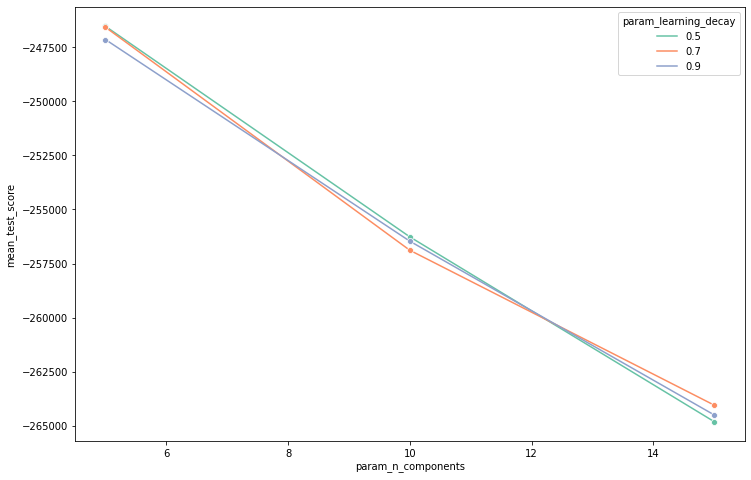

In [13]:
results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o'
            )

plt.show()

# Tópico dominante em cada documento

Para classificar um documento como pertencente a um tópico específico, uma abordagem lógica é ver qual tópico tem a maior contribuição para esse documento e atribuí-lo.

Na tabela abaixo, destaquei em verde todos os principais tópicos de um documento e atribuí o tópico mais dominante em sua própria coluna.

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics_first10 = df_document_topic[:10].style.applymap(color_green).applymap(make_bold)
df_document_topics_first10

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.500000,0.010000,0.410000,0.010000,0.080000,0
Doc1,0.250000,0.010000,0.470000,0.010000,0.270000,2
Doc2,0.000000,0.000000,0.000000,0.980000,0.000000,3
Doc3,0.000000,0.000000,0.320000,0.330000,0.340000,4
Doc4,0.930000,0.000000,0.000000,0.060000,0.000000,0
Doc5,0.010000,0.010000,0.860000,0.010000,0.110000,2
Doc6,0.000000,0.740000,0.010000,0.250000,0.010000,1
Doc7,0.560000,0.180000,0.000000,0.000000,0.260000,0
Doc8,0.630000,0.320000,0.000000,0.040000,0.000000,0
Doc9,0.010000,0.980000,0.010000,0.010000,0.010000,1


# Quantidade de Documentos em Cada Tópico

In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,1371
1,0,540
2,4,484
3,3,429
4,1,294


# Top 5 palavras por tópico

In [16]:
vocab = vectorizer.get_feature_names()

# data_vectorized
topic_words = {}
n_top_words = 5

for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:n_top_words]

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  samba, gente, vem, mar, morro
Topic: 1
  tambem, voce, diz, vovo, fala
Topic: 2
  voce, amor, coracao, quero, mim
Topic: 3
  vai, voce, vem, malandro, deus
Topic: 4
  vou, voce, vai, amor, vida


# Principais Artistas em cada Tópico

In [17]:
# tranformando objeto style em um dataframe pandas
df2 = pd.DataFrame(data=df_document_topics.data, columns=df_document_topics.columns)
df2.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.50,0.01,0.41,0.01,0.08,0
Doc1,0.25,0.01,0.47,0.01,0.27,2
Doc2,0.00,0.00,0.00,0.98,0.00,3
Doc3,0.00,0.00,0.32,0.33,0.34,4
Doc4,0.93,0.00,0.00,0.06,0.00,0


In [18]:
# associando os interpretes aos tópicos 
# dos sambas que eles cantam
df2["artista"] = df["artista"].tolist()
df2.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,artista
Doc0,0.50,0.01,0.41,0.01,0.08,0,Ary Barroso
Doc1,0.25,0.01,0.47,0.01,0.27,2,Arlindo Cruz
Doc2,0.00,0.00,0.00,0.98,0.00,3,Candeia
Doc3,0.00,0.00,0.32,0.33,0.34,4,Alexandre Pires
Doc4,0.93,0.00,0.00,0.06,0.00,0,Ary Barroso


In [19]:
# Artistas que mais aparecem dentro de cada tópico
df2.groupby(["dominant_topic"])['artista'].agg(pd.Series.mode).to_frame()

,artista
dominant_topic,
0,Ary Barroso
1,Bezerra da Silva
2,Belo
3,Bezerra da Silva
4,Benito Di Paula


In [20]:
# os 5 artistas que mais aparecem no
# tópico 0 e quantidade de sambas 
df2[df2["dominant_topic"]==0].groupby(["artista"]).size().sort_values(ascending=False)[:5]

artista
Ary Barroso      110
Alcione           69
Beth Carvalho     53
Arlindo Cruz      41
Agepê             40
dtype: int64

In [21]:
# os 5 artistas que mais aparecem no
# tópico 1 e quantidade de sambas 
df2[df2["dominant_topic"]==1].groupby(["artista"]).size().sort_values(ascending=False)[:5]

artista
Bezerra da Silva    100
Alcione              29
Ataulfo Alves        21
Beth Carvalho        21
Adoniran Barbosa     20
dtype: int64

In [22]:
# os 5 artistas que mais aparecem no
# tópico 2 e quantidade de sambas 
df2[df2["dominant_topic"]==2].groupby(["artista"]).size().sort_values(ascending=False)[:5]

artista
Belo               222
Alcione            190
Alexandre Pires    155
Art Popular        116
Benito Di Paula    105
dtype: int64

In [23]:
# os 5 artistas que mais aparecem no
# tópico 3 e quantidade de sambas 
df2[df2["dominant_topic"]==3].groupby(["artista"]).size().sort_values(ascending=False)[:5]

artista
Bezerra da Silva    120
Art Popular          35
Alcione              35
Beth Carvalho        33
Arlindo Cruz         30
dtype: int64

In [24]:
# os 5 artistas que mais aparecem no
# tópico 4 e quantidade de sambas 
df2[df2["dominant_topic"]==4].groupby(["artista"]).size().sort_values(ascending=False)[:5]

artista
Benito Di Paula    54
Alcione            53
Beth Carvalho      50
Ataulfo Alves      46
Carmen Miranda     42
dtype: int64